# Estudio Inicial

Se comienza explorando el dataset para encontrar características particulares e identificar posibles problemas en las posteriores fases de preparación del dataset y entrenamiento del modelo.

In [24]:
import pandas as pd

#Constants definition
# Csv exported from the Mongodb claim collection with mongoexport
CSV_PATH = './resources/claims.csv'

df = pd.read_csv(CSV_PATH, sep = ",")
df.head()

,text_es,text_en,text_fr,claim
0,Gracias.,Thank you.,Merci.,0
1,Entonces como solo creo que es como la políti...,So as I just think it's like the politics of ...,"Donc, comme je pense que c’est comme la polit...",0
2,Y pienso que el Partido Popular no ha estado ...,And I think the People's Party has not risen ...,Et je pense que le Parti populaire n’a pas ét...,0
3,Lo siguiente Nos vamos ya volando y les dejo ...,The next thing We fly and I leave you with th...,La prochaine chose que nous volons et je vous...,0
4,"Mala noticia para para el el mundo verde, par...","Bad news for the green world, for environment...","Mauvaise nouvelle pour le monde vert, pour l’...",0


A continuación vemos la distribución de textos verificables y no verificables:

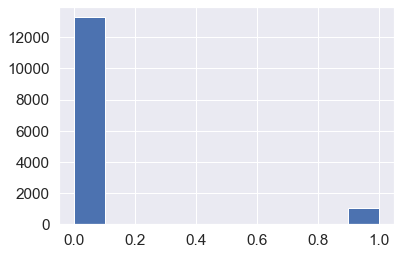

In [25]:
#Column name definition
SPANISH_TEXT_COLUMN = 'text_es'
ENGLISH_TEXT_COLUMN = 'text_en'
FRENCH_TEXT_COLUMN = 'text_fr'
CLAIM_COLUMN = 'claim'

df[CLAIM_COLUMN].hist()

Se puede observar que las tipologías no están equilibradas en cuanto al número de ejemplos. Esto afecta directamente a la fase de entrenamiento del modelo. Dificilmente se obtendrá un buen resultado usando todos los ejemplos del dataset, será mejor reducir el número de ejemplos de textos no verificables.

Tras esto, se comprueba el número de palabras más repetidas para cada tipología.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords


'''
Taken and adapted from: https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
Remove stop words to find the important words
'''
def n_most_frequent_words(corpus, n, lang):
    if lang=='ALL':
        all_stop_words = stopwords.words('spanish') + stopwords.words('english') + stopwords.words('french')
        vectorizer = CountVectorizer(stop_words=all_stop_words)
    else:
        vectorizer = CountVectorizer(stop_words=stopwords.words(lang))
    bag_of_words = vectorizer.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


# Group by label column, get the most frequent words for every language
unique_values = df[CLAIM_COLUMN].unique()
grouped = df.groupby(CLAIM_COLUMN)
most_frequent = {SPANISH_TEXT_COLUMN: {}, ENGLISH_TEXT_COLUMN: {}, FRENCH_TEXT_COLUMN: {}}
for unique in unique_values:
    spanish_rows = grouped[SPANISH_TEXT_COLUMN].get_group(unique)
    english_rows = grouped[ENGLISH_TEXT_COLUMN].get_group(unique)
    french_rows = grouped[FRENCH_TEXT_COLUMN].get_group(unique)
    most_frequent[SPANISH_TEXT_COLUMN][unique] = n_most_frequent_words(spanish_rows.values.astype('U'), 10, 'spanish')
    most_frequent[ENGLISH_TEXT_COLUMN][unique] = n_most_frequent_words(english_rows.values.astype('U'), 10, 'english')
    most_frequent[FRENCH_TEXT_COLUMN][unique] = n_most_frequent_words(french_rows.values.astype('U'), 10, 'french')
    
most_frequent

{'text_es': {0: [('gobierno', 1045),
   ('si', 896),
   ('partido', 793),
   ('creo', 779),
   ('españa', 667),
   ('bueno', 525),
   ('va', 505),
   ('hacer', 479),
   ('popular', 476),
   ('ser', 475)],
  1: [('españa', 147),
   ('ciento', 132),
   ('gobierno', 128),
   ('partido', 106),
   ('millones', 105),
   ('año', 74),
   ('país', 72),
   ('dos', 67),
   ('países', 63),
   ('euros', 63)]},
 'text_en': {0: [('also', 1086),
   ('government', 1040),
   ('think', 854),
   ('party', 780),
   ('us', 763),
   ('people', 762),
   ('well', 761),
   ('going', 674),
   ('spain', 665),
   ('one', 635)],
  1: [('spain', 145),
   ('government', 129),
   ('also', 119),
   ('party', 103),
   ('people', 96),
   ('health', 94),
   ('already', 93),
   ('country', 78),
   ('percent', 73),
   ('last', 70)]},
 'text_fr': {0: [('cette', 1140),
   ('être', 1094),
   ('plus', 1088),
   ('parce', 1049),
   ('gouvernement', 1025),
   ('bien', 962),
   ('très', 934),
   ('comme', 887),
   ('si', 827),
   

Se puede observar que para ambas tipologías aparecen repetidas las mismas palabras, como "españa", "gobierno" y "partido". Esto nos indica que técnicas de *embedding* como *bag-of-words* o *TF-IDF* no son adecuadas para resolver este problema, y parece más indicado a ser resuelto con técnicas de *embedding* que tengan en cuenta el contexto, como BERT.

Para comprobar esto, se puede hacer una pequeña comprobación inicial del contexto que acompaña a las palabras problemáticas según si el texto es verificable o no. Se van a eliminar las *stop-words* para ver las palabras.

In [27]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


conflictive_words = ["españa", "gobierno", "partido"]
stops = set(stopwords.words("spanish"))

unique_values = df[CLAIM_COLUMN].unique()
grouped = df.groupby(CLAIM_COLUMN)
for word in conflictive_words:
    for unique in unique_values:
        spanish_rows = grouped[SPANISH_TEXT_COLUMN].get_group(unique)
        text = spanish_rows.str.cat(sep='. ')
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word.lower() not in stops]
        print("-----------------------------")
        print("Claim: ", unique, ". Word: ", word)
        print("-----------------------------")
        nltk.Text(filtered_tokens).concordance(word, lines=5)

-----------------------------
Claim:  0 . Word:  españa
-----------------------------
Displaying 5 of 528 matches:
io cuestiones judiciales abiertas.. España cabemos igualdad españoles cohesión
rno quitarle despojarle título real España ? . verdad parece aquí.. Ud cree co
 , . , creo amplitud partido grande España , permite hoy tener personas refere
ones Comisión Reconstrucción.. Aquí España haríamos misma prueba poder volar p
 esperamos hoy acuerdo buen acuerdo España agradecemos solidaridad miembros Un
-----------------------------
Claim:  1 . Word:  españa
-----------------------------
Displaying 5 of 129 matches:
víctimas.. aportación hace Gobierno España 6 ciento hace Gobierno holandés.. p
ncuestas dicen sacaríamos escaños.. España segundo país Unión Europea creciend
n 80 ciento Andalucía años.. cambio España habla , pues país ido.. Datos llega
os llegada turistas internacionales España mes junio llegaron apenas 204000 tu
punto vista estabilización región , España hace tiempo prim

Realizando un pequeño análisis de los resultados anteriores, se puede observar cómo en aquellos textos verificables hay una mayor presencia de cifras numéricas y porcentajes con respecto a los textos no verificables.

Esto se puede ver por ejemplo ver en los textos verificables: "*80 ciento Andalucía años.. cambio España habla , pues país ido.. Datos llega*", "*llegada turistas internacionales España mes junio llegaron apenas 204000*" o "*hace Gobierno España 6 ciento hace Gobierno holandés.. pasando sabiendo vuelos*"

A continuación buscamos cadenas de caracteres como correos electrónicos o URLs que debamos normalizar:

In [28]:
pd.set_option('max_colwidth', 300)
df[df[SPANISH_TEXT_COLUMN].str.contains("@")][SPANISH_TEXT_COLUMN]

4996     Y hay que recordar con el voto sólo a favor del Partido Socialista y en contra del Partido Popular de Ciudadanos de junt@s.
Name: text_es, dtype: object

In [29]:
df[df[SPANISH_TEXT_COLUMN].str.contains("www")][SPANISH_TEXT_COLUMN]

Series([], Name: text_es, dtype: object)

No parece haber URLs ni direcciones email en el dataset. La limpieza o normalización de estas cadenas no será necesaria, aunque en un problema real realizar la limpieza no estaría de más.

## Conclusión

Una vez realizado este estudio de los datos hay varias consideraciones a tener en cuenta:
- **Embedding**: debido a la importancia del contexto, se ha de utilizar técnicas que tenga en cuenta el contexto, como BERT
- **Stop-words**: igualmente, por la importancia del contexto, y como se han descartado los embeddings del estilo *bag-of-words* o *TF-IDF*, a priori no parece necesaria la eliminación de *stop-words*. Sin embargo, si los resultados del entrenamiento y validación no fuesen aceptables, se podría probar a eliminar las *stop-words* para ver si así mejoran.
- **Normalización**: como parte de la limpieza del dataset inicial se buscarán ciertas cadenas de texto que se sustituirán por tokens. Como se ha visto no es necesarior realizarlo con URLs ni direcciones de correos. Durante los experimentos de entrenamiento podría realizarse este proceso para números, de tal forma que todos los números queden normalizados al mismo token, ya que no parece que números específicos determinen si un texto es verificable o no. También podría realizarse para fechas. Sería necesario realizar varios experimentos para comparar resultados.
- **Dataset**: vista la distribución no equitativa entre textos verificables y no verificables, no se utilizará el dataset al completo, sino que se realizará una selección de los ejemplos no verificables para reducir su número.

# Entrenamiento del clasificador

En este apartado se procederá a:
1. Preprocesado: limpieza y tokenización del texto.
2. *Embedding*.
3. Separación del modelo en entrenamiento y prueba.
4. Entrenamiento.
5. Test.


## Preprocesado

Para el preprocesado del texto se realizarán los siguientes pasos:
* Dado que se va a utilizar una versión multilingüe preentrenada de BERT sensible a mayúsculas, no es necesario realizar transformaciones de mayúsculas.
* Limpieza de patrones específicos y sustitución por tokens: direcciones web, direcciones de corrreos (no hay en el dataset actual, pero en un problema real podría haberlas).
* No es necesario limpiar *ñ*, tildes u otros caracteres poco comunes.
* En un primer experimento no se eliminarán *stop-words*.

In [30]:
import re

# Cleaning function
def clean(contents):
    # Change URLs
    contents = re.compile('(http|https)://[^\s]*').sub(' <httpaddr> ', contents)
    # Chage email addresses
    contents = re.compile('[^\s]+@[^\s]+').sub(' emailaddr ', contents)
    return contents

# Cleaning the dataset
df[SPANISH_TEXT_COLUMN] = df[SPANISH_TEXT_COLUMN].map(clean, na_action='ignore').astype(str)
df[ENGLISH_TEXT_COLUMN] = df[ENGLISH_TEXT_COLUMN].map(clean, na_action='ignore').astype(str)
df[FRENCH_TEXT_COLUMN] = df[FRENCH_TEXT_COLUMN].map(clean, na_action='ignore').astype(str)
df.head()

,text_es,text_en,text_fr,claim
0,Gracias.,Thank you.,Merci.,0
1,"Entonces como solo creo que es como la política de la casa de todos nosotros ya que aquí no hay milagros y por tanto lo que le diría es que nosotros celebramos el acuerdo de Bruselas, pero que el Gobierno tendrá que cambiar su modelo, su modelo de política en todo lo que tiene que ver desde lue...","So as I just think it's like the politics of the house of all of us because there are no miracles here and therefore what I would tell you is that we celebrate the Brussels agreement, but that the Government will have to change its model, its model of policy in everything that has certainly to ...","Donc, comme je pense que c’est comme la politique de la maison de chacun d’entre nous parce qu’il n’y a pas de miracles ici et donc ce que je vous dirais, c’est que nous célébrons l’accord de Bruxelles, mais que le gouvernement devra changer son modèle, son modèle de politique dans tout ce qui ...",0
2,Y pienso que el Partido Popular no ha estado a la altura de las circunstancias.,And I think the People's Party has not risen to the occasion.,Et je pense que le Parti populaire n’a pas été à la hauteur.,0
3,Lo siguiente Nos vamos ya volando y les dejo con los informativos de la Sexta Noticias con Ana cuesta toda la información durante todo el día.,The next thing We fly and I leave you with the news of the Sixth News with Ana costs all the information throughout the day.,La prochaine chose que nous volons et je vous laisse avec les nouvelles de la Sixième Nouvelles avec Ana coûte toutes les informations tout au long de la journée.,0
4,"Mala noticia para para el el mundo verde, para el ecologismo.","Bad news for the green world, for environmentalism.","Mauvaise nouvelle pour le monde vert, pour l’environnementalisme.",0


## *Train* y *Test*

Debido a que el número de ejemplos de una tipología es bastante mayor al de la otra, y ya que se busca entrenar un modelo multiligüe y disponemos de datos en tres idiomas, se va a seguir la siguiente estrategia para formar el conjunto de entrenamiento:
1. Se creará un nuevo dataset con solo dos columnas. Una columna con el texto (que puede estar en cualquiera de los tres idiomas) y otra con la columna a predecir.
2. Para los ejemplos de frases no verificables *(claim=0)*, se escogerá para incluir en el nuevo dataset la frase en uno solo de los idiomas, alternando entre idiomas para cada fila, de tal manera que haya un número similar de frase no verificables de cada idioma.
3. Para los ejemplos de frases verificables, que son minoría, se incluirá en el nuevo dataset la frase traducida en los tres idiomas. De esta forma, cada entrada de frase verificable del dataset original  producirá tres entradas, se incrementará su número por tres.
4. De este nuevo dataset, se escogerán aleatoriamente un 80% del dataset como entrenamiento, y se dejará el 20% como test. Asimismo, si fuese necesario validar con un porcentaje mayor, se podrán utilizar las frases no verificables en varios idiomas descartadas en el paso 2.

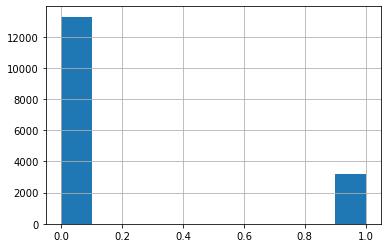

In [2]:
TEXT_COLUMN = 'text'
OUT_NEW_CSV_PATH = './resources/new_claims.csv'

# Loop through the dataframe
new_dataframe = pd.DataFrame()
non_claim_dataframe = pd.DataFrame()
i = 1
for index, row in df.iterrows():
    # If claim=1 we add the sentence to the new dataframe usint the three different languages
    if row[CLAIM_COLUMN] == 1:
        data = pd.DataFrame({TEXT_COLUMN: [row[SPANISH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        new_dataframe = new_dataframe.append(data)
        data = pd.DataFrame({TEXT_COLUMN: [row[ENGLISH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        new_dataframe = new_dataframe.append(data)
        data = pd.DataFrame({TEXT_COLUMN: [row[FRENCH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        new_dataframe = new_dataframe.append(data)
    # If claim=1 we add the sentence alternating between the languages
    elif row[CLAIM_COLUMN] == 0:
        if i%3==0:
            data = pd.DataFrame({TEXT_COLUMN: [row[SPANISH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        elif i%3==1:
            data = pd.DataFrame({TEXT_COLUMN: [row[ENGLISH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        elif i%3==2:
            data = pd.DataFrame({TEXT_COLUMN: [row[FRENCH_TEXT_COLUMN]], CLAIM_COLUMN:  [row[CLAIM_COLUMN]]})
        non_claim_dataframe = non_claim_dataframe.append(data)
    i = i+1
    
# We are left with a fraction of the negative examples. We use the whole set in this case
non_claim_dataframe = non_claim_dataframe.sample(frac=1.0)
new_dataframe = pd.concat([new_dataframe, non_claim_dataframe])

# We write the new dataframe to csv so that this process does not have to be repeated  
new_dataframe.to_csv(OUT_NEW_CSV_PATH, sep=',', encoding='utf-8')
new_dataframe[CLAIM_COLUMN].hist()

In [3]:
import numpy as np

# Split in to train and test datasets
msk = np.random.rand(len(new_dataframe)) < 0.8
train = new_dataframe[msk].to_numpy()
test = new_dataframe[~msk].to_numpy()

## Entrenamiento

El entrenamiento del modelo se realizará utilizando Keras, y de una manera similar a las que se encuentran en https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/ y https://www.tensorflow.org/tutorials/text/classify_text_with_bert, ya que ambos problemas comparten características, como la utilización de Bert y el querer realizar una clasificación binaria.

Para realizar en entrenamiento se ha decido utilizar Tensorflow y Keras. Son librerías más complejas de utilizar con respecto a Sklearn, pero ofrecen una capacidad de *customización* del modelo mucho mayor.

### Tokenización y embedding

En este apartado se realiza:
1. La carga del modelo Bert preentrenado multilingüe sensible a mayúsculas.
2. Tokenización y *embedding* de los textos utilizando el modelo anterior.
3. Se igualan las longitudes de los vectores.
4. Transformación del resultado al dataset de Tensorflow

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert
from transformers import AutoTokenizer

# Constants
BERT_TOKENIZER_MODEL = 'bert-base-multilingual-cased'

tokenizer = AutoTokenizer.from_pretrained(BERT_TOKENIZER_MODEL)

In [5]:
DATASET_BATCH_SIZE = 32

def tokenize_text(text):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text))


def create_tf_dataset(dataset):
    tokenized_dataset = [tokenize_text(text) for text in dataset[:,0]]
    
    # Different texts have different lenghts
    texts_with_len = [[text, dataset[i,1], len(text)]
                     for i, text in enumerate(tokenized_dataset)]

    # Sort the texts by lenght
    texts_with_len.sort(key=lambda x: x[2])
    # Remove the length
    sorted_text_labels = [(text_lab[0], text_lab[1]) for text_lab in texts_with_len]

    # Dataset to tf2 format
    processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_text_labels, output_types=(tf.int32, tf.int32))

    # Padding to solve the length difference problem
    batched_dataset = processed_dataset.padded_batch(DATASET_BATCH_SIZE, padded_shapes=((None, ), ()))
    return batched_dataset

### Modelo

El modelo que se utilizará es una CNN:
- Dos capas de convolución. Para los datos disponibles será suficiente e incluso puede que provoquen un sobreajuste. El tamaño de kernel de estas capas será mínimo.
- Una capa de *pooling* para consolidar el aprendizaje.
- Una capa densa con activación relu seguida de una capa *Dropout* para evitar el sobreajuste.
- Una capa Densa final con activación sigmoide para obtener el resultado de la clasificación binaria final.

Como las CNN aprenden muy rápido y el dataset del que se dispone no es muy grande, el número de *epochs* que se usa será pequeño.

In [6]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 cnn_kernel_size=1,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=cnn_kernel_size,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=cnn_kernel_size,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        
        concatenated = tf.concat([l_1, l_2], axis=-1) # (batch_size, 2 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output
    

VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256

DROPOUT_RATE = 0.2

NB_EPOCHS = 4

text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=2,
                        dropout_rate=DROPOUT_RATE,
                       cnn_kernel_size=1)

text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])

### Ejecución del entrenamiento

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

SAVED_MODEL = 'claims_beto_text_model'

batched_dataset = create_tf_dataset(train)
text_model.fit(batched_dataset, epochs=NB_EPOCHS)

text_model.save(SAVED_MODEL)

Epoch 1/4
413/413 [==============================] - 14s 26ms/step - loss: 0.4044 - accuracy: 0.8293
Epoch 2/4
413/413 [==============================] - 6s 13ms/step - loss: 0.2216 - accuracy: 0.9159
Epoch 3/4
413/413 [==============================] - 6s 14ms/step - loss: 0.0920 - accuracy: 0.9677
Epoch 4/4
413/413 [==============================] - 6s 13ms/step - loss: 0.0306 - accuracy: 0.9914
INFO:tensorflow:Assets written to: claims_beto_text_model\assets


El entrenamiento ha alcanzado un *accuracy* de 0.99 con tan solo 4 *epochs*. Es un porcentaje muy alto y seguramente indique cierto grado de sobreajuste.

### Evaluación

In [8]:
test_dataset = create_tf_dataset(test)
results = text_model.evaluate(test_dataset)
print(results)

103/103 [==============================] - 1s 7ms/step - loss: 0.4550 - accuracy: 0.8746
[0.45498916506767273, 0.874618649482727]


La evaluación da un nivel de acierto bastante alto, pero no hay que confiarse. Debido a la gran cantidad de ejemplos negativos y al pequeño número de positivos podría darse el caso de que el clasificador no estuviera funcionando realmente y esté prediciendo todo como negativo, acertando así en un gran porcentaje.

Es necesario realizar un estudio más detallado, que se realizará en el siguiente apartado.

# Estudio de resultados

En este apartado se realiza un estudio de la solución y los resultados. Esto incluye un desglose de los aciertos y los fallos en el conjunto de validación, y un análisis del funcionamiento del clasificador con respecto al dataset completo original (recordemos que se descartaron ejemplos negativos en distintos idiomas).

### Matriz de confusión para conjunto de validación

Para poder evaluar realmente el funcionamiento del clasificador con el conjunto de validación se va calcular la matriz de confusión.

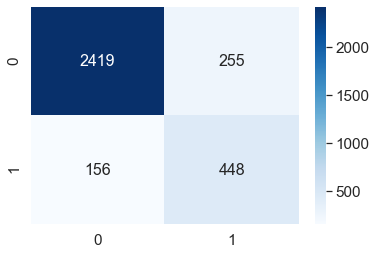

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

def predict_and_show_matrix(test_dataset, text_model):
    real_claims = np.concatenate([y for x, y in test_dataset], axis=0).tolist()
    predictions = text_model.predict(test_dataset)
    predictions = np.where(predictions[:,0] <= 0.5, 0, 1).tolist()

    matrix = confusion_matrix(real_claims, predictions)

    df_cm = pd.DataFrame(matrix, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 16}) # font size
    plt.show()

predict_and_show_matrix(test_dataset, text_model)

Se puede observar que aunque de manera general hay un 87% de acierto, el porcentaje de acierto para los ejemplos positivos es menor y cerca de un 25% de los ejemplos positivos se clasifican de manera incorrecta. El número de falsos positivos no parece alto, sin embargo si se compara con el número de positivos reales también es alto.

Es lógico que el número de falsos negativos sea relativamente alto, ya que en el dataset utilizado para entrenar había una gran cantidad de ejemplos negativos.
Posibles soluciones para esto incluyen:
- Reducir todavía más el número de ejemplos negativos utilizados para entrenar. Aunque esto podría aumentar el número de falsos positivos.
- Retocar los parámetros del modelo y el número de iteraciones utilizadas para reducir el sobreajuste.
- Probar con un modelo diferente (una red neuronal no CNN, etc.)
- Diseñar funciones *ad-hoc* de activación para reducir el número de falsos negativos o de falsos positivos, haciendo un estudio de cual de estos fenómenos tiene un mayor impacto negativo en el proyecto y tomando en base a esto una decisión.

### Funcionamiento del modelo para el conjunto original completo

Debido a que para el entrenamiento se descartaron una gran cantidad de ejemplos en varios idiomas, ahora se procede a evaluar el conjunto inicial en su totalidad, haciendo un estudio similar al realizado con el conjunto de validación pero añadiendo comprobaciones por idioma, para cercionarnos de que el modelo funciona de manera similar en todos los idiomas.

Se comienza transformando el dataset incial al completo al formato que se ha seguido al entrenar para poder evaluarlo.

In [10]:
full_dataframe = pd.DataFrame(columns=[TEXT_COLUMN, CLAIM_COLUMN])
renamed_sp = df.rename(columns={SPANISH_TEXT_COLUMN: TEXT_COLUMN}, inplace=False)
full_dataframe = full_dataframe.append(renamed_sp[[TEXT_COLUMN,CLAIM_COLUMN]]).reset_index(drop=True)
renamed_en = df.rename(columns={ENGLISH_TEXT_COLUMN: TEXT_COLUMN}, inplace=False)
full_dataframe = full_dataframe.append(renamed_en[[TEXT_COLUMN,CLAIM_COLUMN]]).reset_index(drop=True)
renamed_fr = df.rename(columns={FRENCH_TEXT_COLUMN: TEXT_COLUMN}, inplace=False)
full_dataframe = full_dataframe.append(renamed_fr[[TEXT_COLUMN,CLAIM_COLUMN]]).reset_index(drop=True)
full_dataframe

,text,claim
0,Gracias.,0
1,Entonces como solo creo que es como la políti...,0
2,Y pienso que el Partido Popular no ha estado ...,0
3,Lo siguiente Nos vamos ya volando y les dejo ...,0
4,"Mala noticia para para el el mundo verde, par...",0
...,...,...
43054,"Au cours des derniers mois, nous avons présen...",0
43055,"L’oasis du système de santé, en plus de donne...",0
43056,"Eh bien, je pose des questions sur les inform...",0
43057,Comment pensez-vous que cela affecte la Couro...,0


Calculamos la matriz de confusión para el dataset al completo:

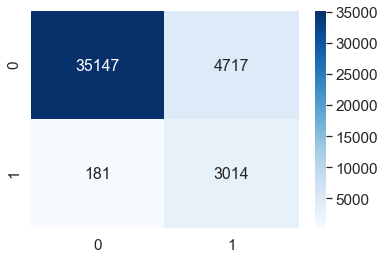

In [11]:
full_test_dataset = create_tf_dataset(full_dataframe.to_numpy())
predict_and_show_matrix(full_test_dataset, text_model)

Podemos ver que el número de falsos positivos se mantiene en un nivel parecido al encontrado en el conjunto de validación. Sin embargo lo preocupante es el número de falsos negativos, su número es mayor incluso que el de los positivos realmente acertados.

Para comprobar si el modelo entrenado es realmente multilingüe y que estos problemas no los está causando un idioma en particular, vamos a realizar este mismo estudio de manera separada para cada idioma.

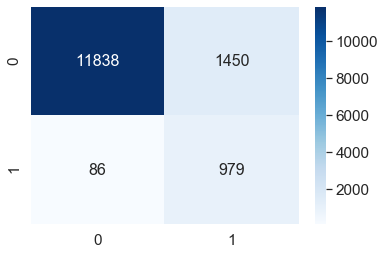

In [12]:

'''
Function that creates a dataframe with the texts of a particular language, applies the model and shows the confusion matrix
for the predictions
'''
def predict_and_show_matrix_by_lang(text_model, original_dataframe, lang_column):
    lang_dataframe = pd.DataFrame(columns=[TEXT_COLUMN, CLAIM_COLUMN])
    renamed_lang = original_dataframe.rename(columns={lang_column: TEXT_COLUMN}, inplace=False)
    lang_dataframe = lang_dataframe.append(renamed_lang[[TEXT_COLUMN,CLAIM_COLUMN]]).reset_index(drop=True)

    lang_test_dataset = create_tf_dataset(lang_dataframe.to_numpy())
    predict_and_show_matrix(lang_test_dataset, text_model)
    
predict_and_show_matrix_by_lang(text_model, df, SPANISH_TEXT_COLUMN)

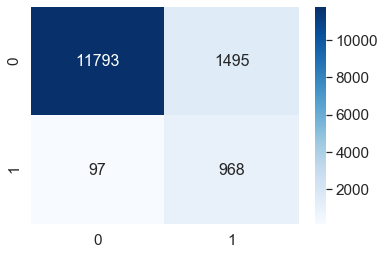

In [13]:
predict_and_show_matrix_by_lang(text_model, df, ENGLISH_TEXT_COLUMN)

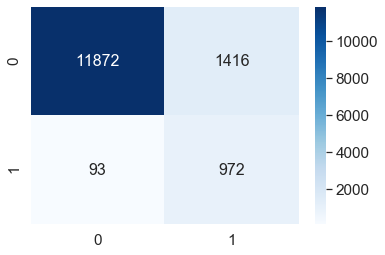

In [14]:
predict_and_show_matrix_by_lang(text_model, df, FRENCH_TEXT_COLUMN)

En las tres anteriores matrices de confusión se puede ver que el modelo funciona de manera similar para los tres idiomas.

### Análisis de falsos positivos

A continuación se realizará un análisis similar al realizado en el estudio inicial de exploración del dataset, en el que se buscarán las palabras más repetidas para los falsos negativos y su contexto, para buscar algún patrón común por el que el clasificador no esté funcionando correctamente.

Se crea un dataset añadiendo la columna relativa a la predicción:

In [23]:
CLAIM_PREDICTED_COLUMN = 'claim_predicted'
OUT_VALIDATION_CSV_PATH = './resources/validation_claims.csv'

print(full_dataframe[TEXT_COLUMN].head())
text_dataset = full_dataframe[TEXT_COLUMN].to_numpy()
texts_with_len = [[text, len(text)] for i, text in enumerate(text_dataset)]
texts_with_len.sort(key=lambda x: x[1])
real_claims_texts = [t[0] for t in texts_with_len]

real_claims = np.concatenate([y for x, y in full_test_dataset], axis=0).tolist()
predictions = text_model.predict(full_test_dataset)
predictions = np.where(predictions[:,0] <= 0.5, 0, 1).tolist()
pred_dc = {TEXT_COLUMN: real_claims_texts, CLAIM_COLUMN: real_claims, CLAIM_PREDICTED_COLUMN: predictions}
prediction_df = pd.DataFrame(pred_dc)
# We write the dataframe to csv
prediction_df.to_csv(OUT_VALIDATION_CSV_PATH, sep=',', encoding='utf-8', index=False)
prediction_df.tail()

0                                             Gracias.
1     Entonces como solo creo que es como la políti...
2     Y pienso que el Partido Popular no ha estado ...
3     Lo siguiente Nos vamos ya volando y les dejo ...
4     Mala noticia para para el el mundo verde, par...
Name: text, dtype: object


,text,claim,claim_predicted
43054,"Procureur de l’homme Pues, qui appelle le pro...",0,0
43055,Por eso la coalición Partido Popular Ciudadan...,0,0
43056,That is why the Coalition People's Citizens P...,0,0
43057,C’est pourquoi le Parti des citoyens du peupl...,0,0
43058,"Eh bien, bonjour avec nous semblons à quelque...",0,0


Restringimos a los falsos positivos:

In [16]:
false_positives_df = prediction_df.loc[(prediction_df[CLAIM_COLUMN]==0) & (prediction_df[CLAIM_PREDICTED_COLUMN]==1)]
false_positives_df.tail()

,text,claim,claim_predicted
42912,. Il y a donc aussi des encouragements à ce qu...,0,1
42934,22 minutes à neuf heures du matin vingt-deux ...,0,1
42976,"So beyond that, we hope that the Government, ...",0,1
42994,C’est pourquoi il est important que la loi so...,0,1
43026,"Tout d’abord, lorsque nous avons reçu ce juge...",0,1


Buscamos las palabras más repetidas:

In [31]:
most_frequent = n_most_frequent_words(false_positives_df[TEXT_COLUMN].values.astype('U'), 10, 'ALL')
most_frequent

[('si', 230),
 ('plus', 177),
 ('gouvernement', 159),
 ('parce', 158),
 ('bien', 157),
 ('also', 156),
 ('gobierno', 152),
 ('cette', 151),
 ('être', 140),
 ('government', 140)]

Podemos ver que las palabras relativas a "gobierno" en varios idiomas siguen siendo problemáticas

In [20]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


conflictive_words = ["government", "gobierno", "gouvernement"]
stops = set.union(set.union(set(stopwords.words("spanish")), set(stopwords.words("english"))),set(stopwords.words("french")))

for word in conflictive_words:
    text = false_positives_df[TEXT_COLUMN].str.cat(sep='. ')
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stops]
    print("-----------------------------")
    print(". Word: ", word)
    print("-----------------------------")
    nltk.Text(filtered_tokens).concordance(word, lines=10)

-----------------------------
. Word:  government
-----------------------------
Displaying 10 of 131 matches:
k 's needs done case.. commitment Government Spain them.. even want take opini
 Mr. Sanchez going us side.. case Government Spain , be.. regard elections Bas
going fall whole.. n't give trust government Pedro Sánchez.. seen throughout p
ndments.. great example Andalusia Government Panama.. Come , set 're middle pa
and question completely logical.. government always priority , saving lives.. 
tening Quim Torra.. n't want give government , let 's say real mass.. beginnin
urse legal text analyzed.. happen Government Spain move nowhere.. map key sect
.. also raised petition President Government Spain.. Well , maybe 're becoming
alucía Director Tourism.. believe government sometimes confuses priorities han
 Spaniards that.. course , assure Government Spain treated something.. course 
-----------------------------
. Word:  gobierno
-----------------------------
Displaying 10 of 140 m

A priori, con una muestra tan reducida, no parece que haya ningún patrón facilmente identificable que sirva para explicar de manera inmediata el problema de los falsos positivos.
Sin embargo, sí que parece que las frases que contienen la palabra "gobierno" en todos los idiomas resultan problemáticas. Ayudaría disponer de más ejemplos negativos que contengan esta palabra, para que así el modelo a entrenar tenga en cuenta más contextos diferentes y se reduzca el número de falsos positivos.

### Conclusiones

Después de realizar el estudio se pueden concluir los siguientes puntos:
- El modelo entrenado presenta un porcentaje de acierto alto tanto con el conjunto de entrenamiento, como con el pequeño conjunto de validación, y con el dataset al completo.
- Hay un alto procentaje de falsos positivos, posiblemente debido a un sobreajuste con respecto a los ejemplos positivos.
- El modelo entrenado es multilingüe, ya que se ha observado un comportamiento similar para los tres diferentes idiomas.

Trabajo futuro:
- Modificar el conjunto de entrenamiento inicial, añadiendo más ejemplos negativos que contengan la palabra "gobierno" y sus variantes en los otros idiomas si es posible, para reducir el número de falsos positivos.
- Probar a normalizar números y fechas para entrenar el modelo.
- Diseñar una función de activación personalizada para reducir el número de falsos positivos.
- Realizar más experimentos, cambiando los parámetros de la red utilizada y utilizando otros modelos de *machine-learning* diferentes.
- Se puede incluso pensar en entrenar varios modelos que funcionen en producción de manera simultánea mediante un algoritmo heurístico orquestador que combine los resultados de cada modelo en base a las debilidades y fortalezas identificadas de cada uno.